# setup

In [1]:
%matplotlib inline
import eelbrain as eel
import numpy as np
import scipy, pathlib, importlib, mne, time, os, statsmodels, statsmodels.stats.multitest
from tqdm import tqdm
import matplotlib.pyplot as plt
import preprocessing as pre
import models as md
import plotting
from pathnames import *
importlib.reload(pre)
importlib.reload(md)
importlib.reload(plotting)

mne.set_log_level(verbose='error')

# CHANGE PATH HERE
out_path_post.mkdir(exist_ok=True, parents=True)

subjects = [f'part_{i:03d}' for i in range(1, 26) if i not in [12]]

## function: process_trf

In [2]:
def process_trf(tt, trftime=(-0.01, 0.03), pktime=(0.004, 0.009), snrtime=(0, 0.015), baselinetime=(-0.01,0), sm=0.002, snrflag=True):
    tt = eel.resample(eel.filter_data(tt, 30, 500), 16384)
    tt -= tt.sub(time=baselinetime).mean('time')
    tt = eel.resample(tt, 16384)

    # get wave V peak
    ttpk = tt.sub(time=pktime)
    maxima = scipy.signal.argrelextrema(ttpk.x, np.greater)
    if len(maxima[0])==0:
        pkidx = np.argmax(ttpk.x)
    else:
        maxima_v = []
        for m in maxima[0]:
            maxima_v.append(ttpk.x[m])
        pkidx = maxima[0][np.argmax(maxima_v)]
    pktime = ttpk.time.times[pkidx]
    pkamp = tt.sub(time=(pktime))

    # calculate SNR
    if snrflag:
        spow = tt.sub(time=(pktime-0.0025, pktime+0.0025)).var()
        snrwin = 0.005
        tstarts = np.arange(-0.5, -0.02, snrwin)
        npow = 0
        for tstart in tstarts:
            npow += tt.sub(time=(tstart, tstart+snrwin)).var()
        npow /= len(tstarts)
        snr = 10*np.log10(np.max([(spow-npow)/npow, 10**(-0.5)]))
    else:
        snr = None
    return tt, pktime, pkamp, snr

# load trfs

In [3]:
stim_delays = {'in':-0.0009, 'io':-0.0009, 's':-0.0044} # delays for inserts and speakers
stim_delays_trf = {'in':0.0001, 'io':0.0001, 's':-0.0001} # fix for trfs estimated with inserts -1ms and speakers -4.3ms

preds = ['rect', 'rect', 'zilany_hsr', 'zilany_hsr']
predlabels = ['RS', 'RSnull', 'AN', 'ANnull']

# setup result dictionaries
resdict = {}
trftrialdict = {}
corrtrialdict = {}
snrdict = {}
corrdict = {}
pklatsdict = {}
pkampsdict = {}
for stimtype in ['io', 'in', 's']:
    for method in ['erp']:
        resdict[stimtype + '_click_' + method] = []
        pklatsdict[stimtype + '_click_' + method] = []
        pkampsdict[stimtype + '_click_' + method] = []

for stimtype in ['in', 's']:
    for pred in predlabels:
        resdict[stimtype + '_speech_' + pred] = []
        trftrialdict[stimtype + '_speech_'+pred] = []
        corrtrialdict[stimtype + '_speech_'+pred] = []
        snrdict[stimtype + '_speech_'+pred] = []
        corrdict[stimtype + '_speech_' + pred] = []
        pklatsdict[stimtype + '_speech_' + pred] = []
        pkampsdict[stimtype + '_speech_' + pred] = []
        
# time window to detect wave V peak
pkt1 = 0.004
pkt2 = 0.009

fs = 16384

# TRF time window
t1 = -0.01
t2 = 0.03
N = int((t2-t1)*fs)

for subject in tqdm(subjects):
    # Clicks
    for stimtype in ['io', 'in', 's']:
        click_res = eel.load.unpickle(click_path / f'{subject}_{stimtype}_click_erp.pkl')
        trf = click_res['erp']
        trf *= 1e6 # V -> uV
        trf = pre.shift_NDVar(trf, stim_delays[stimtype]) # shift to account for delays
        trf = trf.sub(time=(t1, t2))
        trf = eel.NDVar(trf.x[:N], eel.UTS(t1, trf.time.tstep, N))
        trf -= trf.sub(time=(t1, 0)).mean('time')

        # detect wave V peak
        ttpk = trf.sub(time=(0.004,0.009))
        maxima = scipy.signal.argrelextrema(ttpk.x, np.greater)
        if len(maxima[0])==0:
            pkidx = np.argmax(ttpk.x)
        else:
            maxima_v = []
            for m in maxima[0]:
                maxima_v.append(ttpk.x[m])
            pkidx = maxima[0][np.argmax(maxima_v)]
        pktime = ttpk.time.times[pkidx]
        pkamp = trf.sub(time=(pktime))
        pklatsdict[f'{stimtype}_click_erp'].append(pktime)
        pkampsdict[f'{stimtype}_click_erp'].append(pkamp)
        resdict[f'{stimtype}_click_erp'].append(trf)


    # Speech
    for stimtype in ['in', 's']:
        # some subjects don't have all 8 trials
        if '024' in subject and stimtype=='in':
            trialnum = 5
        elif '018' in subject and stimtype=='in':
            trialnum = 6
        else:
            trialnum = 7 # for 8 trials (indexed starting from 0)
        

        if stimtype == 'in':
            res = eel.load.unpickle(speech_path_in / f'{subject}_{stimtype}_res.pkl')
        elif stimtype == 's':
            res = eel.load.unpickle(speech_path_s / f'{subject}_{stimtype}_res.pkl')
        for k, kl in zip(preds, predlabels):
            # load TRFs for each trial
            trfs = []
            corrs = []
            snrs = []
            pktimes = []
            pkamps = []
            for t in range(1, trialnum+1):
                if 'null' in kl: 
                    kk = f'{k} {t} null'
                    trf1 = res['trfsA'][f'trf {kk}'].copy()
                else: 
                    kk = f'{k} {t}'
                    trf1 = res['trfsA'][f'trf {kk}'].copy()
                trf1 = pre.shift_NDVar(trf1, stim_delays_trf[stimtype]) # shift to account for delays
                tt, pktime, pkamp, snr = process_trf(trf1)
                tt = eel.NDVar(tt.sub(time=(t1, t2+0.1)).x[:N], eel.UTS(t1, tt.time.tstep, N))
                trfs.append(tt)
                pktimes.append(pktime)
                pkamps.append(pkamp)
                corrs.append(res['corrsA'][f'corr {kk}'])
                snrs.append(snr)
            trftrialdict[f'{stimtype}_speech_{kl}'].append(trfs)
            corrtrialdict[f'{stimtype}_speech_{kl}'].append(corrs)
            snrdict[f'{stimtype}_speech_{kl}'].append(snrs)
                
            pklatsdict[f'{stimtype}_speech_{kl}'].append(pktimes[-1])
            pkampsdict[f'{stimtype}_speech_{kl}'].append(pkamps[-1])
            resdict[f'{stimtype}_speech_{kl}'].append(trftrialdict[f'{stimtype}_speech_{kl}'][-1][-1])
            corrdict[f'{stimtype}_speech_{kl}'].append(corrtrialdict[f'{stimtype}_speech_{kl}'][-1][-1])


for k in resdict.keys():
    print(k)
    resdict[k] = eel.combine(resdict[k])


# normalize to be comparable to ERP
gn = {}
for stimtype in ['in', 's']:
    for pred in ['RS', 'AN']:
        gn[f'{stimtype}_speech_{pred}'] = resdict[f'{stimtype}_click_erp'].sub(time=(0,0.02)).std().mean() / resdict[f'{stimtype}_speech_{pred}'].sub(time=(0,0.02)).std().mean()
        resdict[f'{stimtype}_speech_{pred}'] *= gn[f'{stimtype}_speech_{pred}']
        pkampsdict[f'{stimtype}_speech_{pred}'] = [p*gn[f'{stimtype}_speech_{pred}'] for p in pkampsdict[f'{stimtype}_speech_{pred}']]
        resdict[f'{stimtype}_speech_{pred}null'] *= gn[f'{stimtype}_speech_{pred}']
        pkampsdict[f'{stimtype}_speech_{pred}null'] = [p*gn[f'{stimtype}_speech_{pred}'] for p in pkampsdict[f'{stimtype}_speech_{pred}null']]

for k in gn.keys():
    print(k, gn[k])

100%|██████████| 24/24 [02:05<00:00,  5.24s/it]

io_click_erp
in_click_erp
s_click_erp
in_speech_RS
in_speech_RSnull
in_speech_AN
in_speech_ANnull
s_speech_RS
s_speech_RSnull
s_speech_AN
s_speech_ANnull
in_speech_RS 806.7642231412502
in_speech_AN 741.9280548114837
s_speech_RS 728.2149060913264
s_speech_AN 655.615972249691


# print out wave V lats and amps

In [4]:
for k in pklatsdict.keys():
    if 'perm' in k or 'io' in k:
        continue
    print(k, f'latency mean={1000*np.mean(pklatsdict[k])}, std={1000*np.std(pklatsdict[k])}')

in_click_erp latency mean=6.990661621093751, std=0.43331110250397237
s_click_erp latency mean=6.883850097656251, std=0.41426511671457417
in_speech_RS latency mean=6.660729980468627, std=0.6240110968223715
in_speech_RSnull latency mean=6.26145833333321, std=1.5568618244981849
in_speech_AN latency mean=6.440844726562478, std=0.3784056630748671
in_speech_ANnull latency mean=6.779081217447895, std=1.400928491413869
s_speech_RS latency mean=6.174340820312985, std=0.6197523310277531
s_speech_RSnull latency mean=6.805037434896318, std=1.492651389061395
s_speech_AN latency mean=6.104500325520974, std=0.36276859539859646
s_speech_ANnull latency mean=6.493599446614724, std=1.4378906940823017


# ANOVA

In [5]:
predfac = []
subfac = []
snrfac = []
corrfac = []
corrfac = []
stimfac = []
lenfac = []
for pred in ['AN', 'RS']:
    for stim in ['in', 's']:
        for length in range(7):
            for isub, subject in enumerate(subjects):
                if subject in ['part_018', 'part_024']:
                    continue
                predfac.append(pred)
                subfac.append(subject)
                stimfac.append(stim)
                k = f'{stim}_speech_{pred}'
                snrfac.append(snrdict[k][isub][length])
                corrfac.append(corrtrialdict[k][isub][length]-corrtrialdict[k+'null'][isub][length])
                lenfac.append(length)
ds = eel.Dataset()
ds['pred'] = eel.Factor(predfac)
ds['len'] = eel.Factor(lenfac)
ds['lenvar'] = eel.Var(lenfac)
ds['stim'] = eel.Factor(stimfac)
ds['corr'] = eel.Var(corrfac)
ds['subject'] = eel.Factor(subfac, random=True)
ds['snr'] = eel.Var(snrfac)

In [6]:
import statsmodels.stats.multitest

tts = []
kks = []
pps = []
mn1s = []
mn2s = []
dds = []

y1 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="in"').sub('pred=="RS"')['corr']))
y2 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="s"').sub('pred=="RS"')['corr']))
t, pp = scipy.stats.ttest_rel(y1, y2, alternative='two-sided')
kk = f'RS_in_s'
tts.append(t)
pps.append(pp)
kks.append(kk)
mn1s.append(np.mean(y1))
mn2s.append(np.mean(y2))
dds.append(np.mean(y1-y2)/np.std(y1-y2))

y1 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="in"').sub('pred=="AN"')['corr']))
y2 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="s"').sub('pred=="AN"')['corr']))
t, pp = scipy.stats.ttest_rel(y1, y2, alternative='two-sided')
kk = f'AN_in_s'
tts.append(t)
pps.append(pp)
kks.append(kk)
mn1s.append(np.mean(y1))
mn2s.append(np.mean(y2))
dds.append(np.mean(y1-y2)/np.std(y1-y2))

y1 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="in"').sub('pred=="AN"')['corr']))
y2 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="in"').sub('pred=="RS"')['corr']))
t, pp = scipy.stats.ttest_rel(y1, y2, alternative='two-sided')
kk = f'in_AN_RS'
tts.append(t)
pps.append(pp)
kks.append(kk)
mn1s.append(np.mean(y1))
mn2s.append(np.mean(y2))
dds.append(np.mean(y1-y2)/np.std(y1-y2))

y1 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="s"').sub('pred=="AN"')['corr']))
y2 = np.asarray(list(ds.sub(f'len=="6"').sub(f'stim=="s"').sub('pred=="RS"')['corr']))
t, pp = scipy.stats.ttest_rel(y1, y2, alternative='two-sided')
kk = f's_AN_RS'
tts.append(t)
pps.append(pp)
kks.append(kk)
mn1s.append(np.mean(y1))
mn2s.append(np.mean(y2))
dds.append(np.mean(y1-y2)/np.std(y1-y2))

[_, pcorrected, _,_] = statsmodels.stats.multitest.multipletests(pps, method='holm')
pcorrs = pcorrected

for i in range(4):
    print(f'{kks[i]}, m1={mn1s[i]:.3f}, m2={mn2s[i]:.3f}, d={dds[i]:.3f}, t{len(y1)-1}={tts[i]:.3f}, p={pcorrected[i]:.4f}')

RS_in_s, m1=0.008, m2=0.008, d=0.037, t21=0.167, p=0.8687
AN_in_s, m1=0.019, m2=0.016, d=0.457, t21=2.093, p=0.0974
in_AN_RS, m1=0.019, m2=0.008, d=1.811, t21=8.299, p=0.0000
s_AN_RS, m1=0.016, m2=0.008, d=1.855, t21=8.499, p=0.0000


In [7]:
kks = []
pps = []
tts = []
md1s = []
md2s = []
for i in range(1, 7):
    y1 = ds.sub(f'len=="1"').sub(f'stim=="in"').sub('pred=="AN"')['snr']
    y2 = ds.sub(f'len=="{i}"').sub(f'stim=="s"').sub('pred=="AN"')['snr']
    T, pp = scipy.stats.wilcoxon(y1, y2, alternative='two-sided')
    kk = f'12in-{4*i+8}s'
    tts.append(T)
    pps.append(pp)
    kks.append(kk)
    md1s.append(np.median(y1))
    md2s.append(np.median(y2))

[_, pcorrected, _,_] = statsmodels.stats.multitest.multipletests(pps, method='holm')
for kk, pp, ppc, tt, md1, md2 in zip(kks, pps, pcorrected, tts, md1s, md2s):
    print('snr', kk, f'median1={md1:.2f}dB, median2={md2:.2f}dB, T={tt:.2f}, p_corrected={ppc:.3f}')

snr 12in-12s median1=7.39dB, median2=5.84dB, T=41.00, p_corrected=0.012
snr 12in-16s median1=7.39dB, median2=8.74dB, T=111.00, p_corrected=0.633
snr 12in-20s median1=7.39dB, median2=9.41dB, T=42.00, p_corrected=0.012
snr 12in-24s median1=7.39dB, median2=10.50dB, T=26.00, p_corrected=0.002
snr 12in-28s median1=7.39dB, median2=10.67dB, T=14.00, p_corrected=0.000
snr 12in-32s median1=7.39dB, median2=10.98dB, T=14.00, p_corrected=0.000


In [8]:
kks = []
pps = []
tts = []
md1s = []
md2s = []
for stim in ['in', 's']:
    y1 = ds.sub(f'len=="6"').sub(f'stim=="{stim}"').sub('pred=="RS"')['snr']
    y2 = ds.sub(f'len=="6"').sub(f'stim=="{stim}"').sub('pred=="AN"')['snr']
    T, pp = scipy.stats.wilcoxon(y1, y2, alternative='two-sided')
    kk = f'{stim} RSvsAN'
    tts.append(T)
    pps.append(pp)
    kks.append(kk)
    md1s.append(np.median(y1))
    md2s.append(np.median(y2))

[_, pcorrected, _,_] = statsmodels.stats.multitest.multipletests(pps, method='holm')
for kk, pp, ppc, tt, md1, md2 in zip(kks, pps, pcorrected, tts, md1s, md2s):
    print('snr', kk, f'median1={md1:.2f}dB, median2={md2:.2f}dB, T={tt:.2f}, p_corrected={ppc:.3f}')

snr in RSvsAN median1=7.43dB, median2=13.96dB, T=0.00, p_corrected=0.000
snr s RSvsAN median1=4.88dB, median2=10.98dB, T=0.00, p_corrected=0.000


# plot fig 1

0.02164727314128277
0.5583645797091913
0.4990022419848265
0.03642629343637299
0.45983369242528477
0.32767571036626747
0.7375536290133263
0.4511227669661033
in_speech_RS
s_speech_RS
in_speech_AN
s_speech_AN


c:\Users\josku55\Code\SFABR_github\speechABR\plotting.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:.2f}' for y in ylabels])


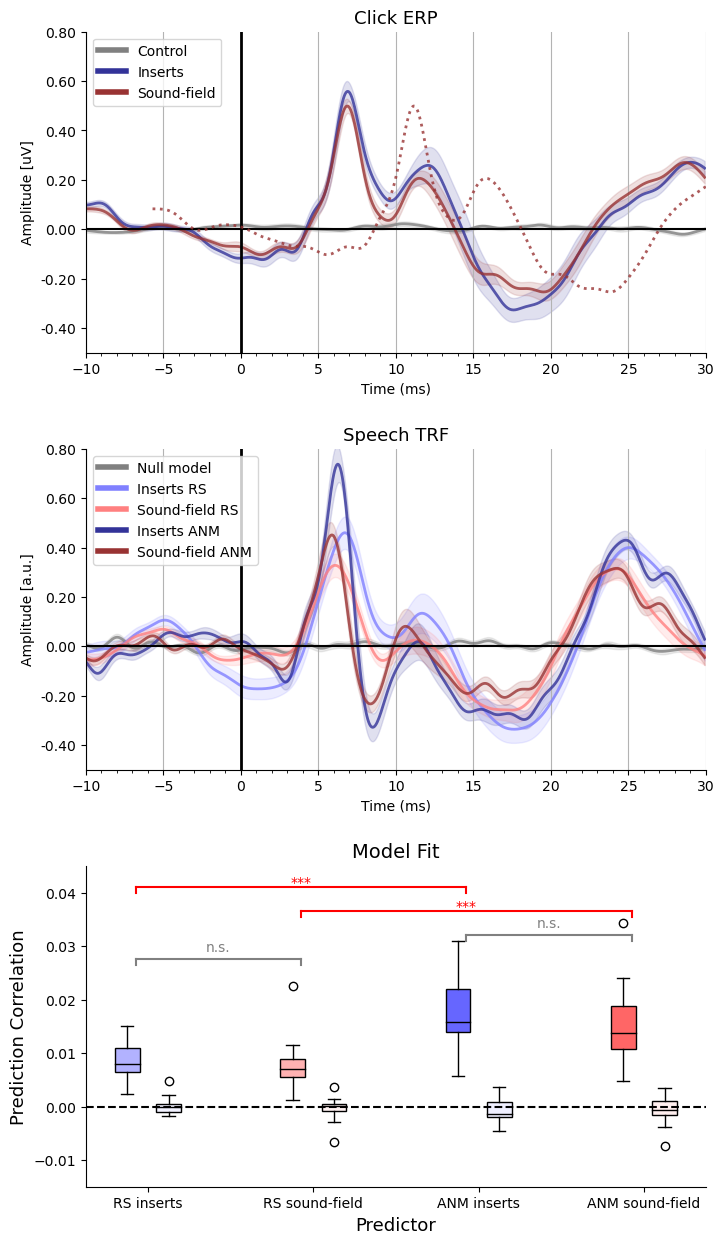

In [9]:
importlib.reload(plotting)
savepath = out_path_post / 'figs_rev1_06'
savepath.mkdir(exist_ok=True, parents=True)
sigbars = [[0, 1, pcorrs[0]],[2, 3, pcorrs[1]],[1, 3, pcorrs[3]], [0, 2, pcorrs[2]],]
plotting.plot_fig_AVG3(resdict, corrdict, savepath, sigbars=sigbars)

In [10]:
# % change in wave V amplitude for inserts vs soundfield
print('click', 100*(np.mean(pkampsdict['in_click_erp'])-np.mean(pkampsdict['s_click_erp']))/np.mean(pkampsdict['in_click_erp']))
print('RS', 100*(np.mean(pkampsdict['in_speech_RS'])-np.mean(pkampsdict['s_speech_RS']))/np.mean(pkampsdict['in_speech_RS']))
print('AN', 100*(np.mean(pkampsdict['in_speech_AN'])-np.mean(pkampsdict['s_speech_AN']))/np.mean(pkampsdict['in_speech_AN']))

click 11.95511826653614
RS 29.18995335386889
AN 36.550116183514284


# plot fig 2

[1.19558651e-06 2.12541699e-02 3.97097331e-04 1.71758750e-06
 6.71246837e-05]
[3.74136781e-05 1.20944874e-02 4.91859049e-06 3.52602732e-03
 5.42135183e-03]
5.57568359375 8.1492919921875
4.51750976562546 8.219428710937372
5.040659179687634 7.579995117187477
5.582456054687479 8.1492919921875
5.040659179687634 7.828857421875
done


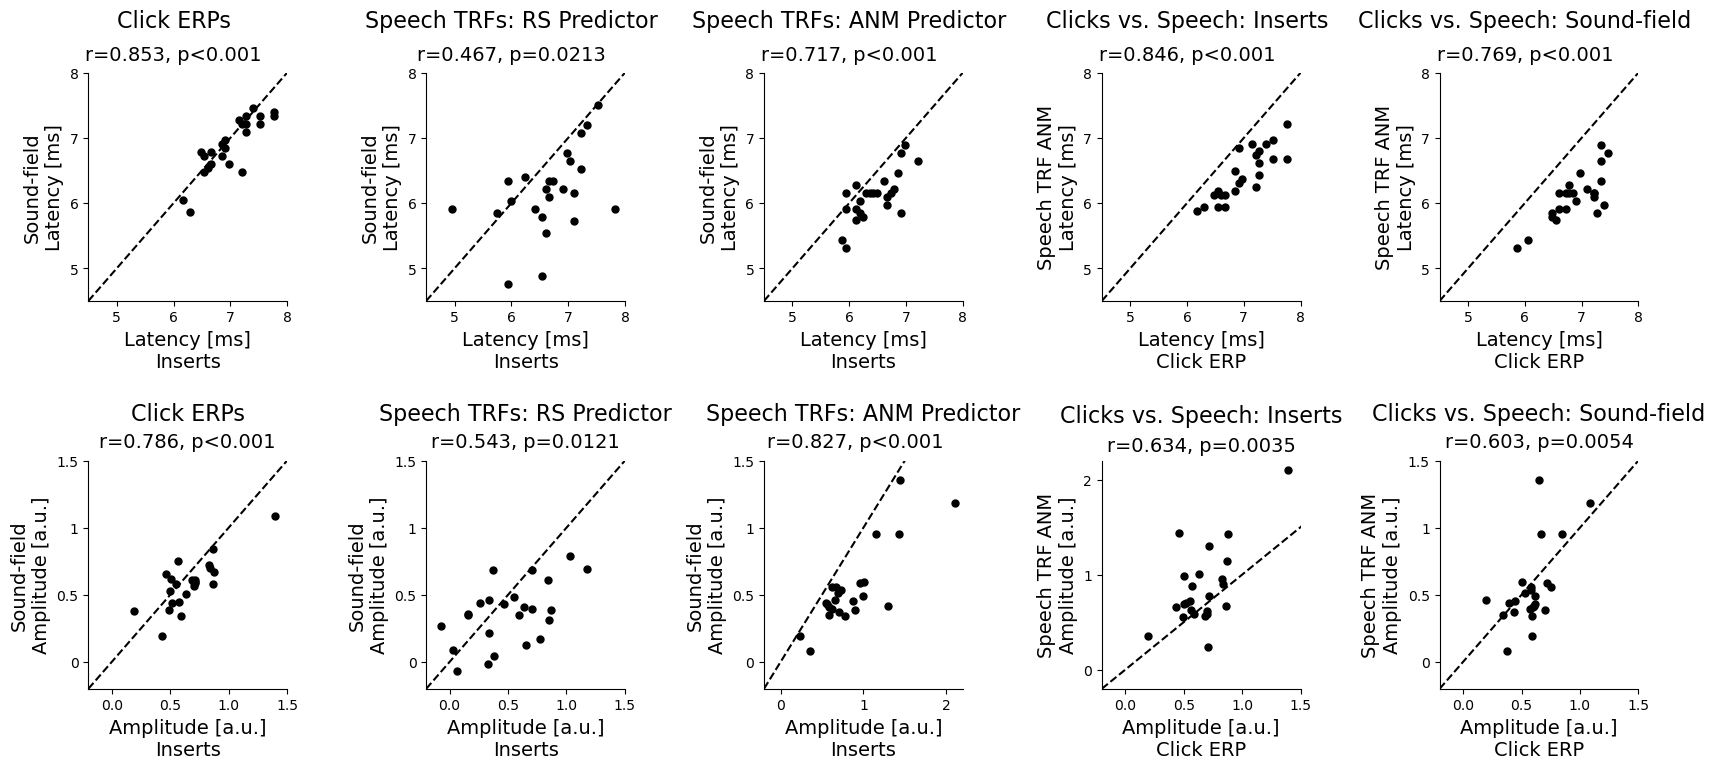

In [11]:
importlib.reload(plotting)
xks = ['in_click_erp', 'in_speech_RS', 'in_speech_AN', 'in_click_erp', 's_click_erp']
yks = ['s_click_erp', 's_speech_RS', 's_speech_AN', 'in_speech_AN', 's_speech_AN']
titles = ['Click ERPs', 'Speech TRFs: RS Predictor', 'Speech TRFs: ANM Predictor', 'Clicks vs. Speech: Inserts', 'Clicks vs. Speech: Sound-field']
xstrs = ['Inserts', 'Inserts', 'Inserts', 'Click ERP', 'Click ERP']
ystrs = ['Sound-field', 'Sound-field', 'Sound-field', 'Speech TRF ANM', 'Speech TRF ANM']
plotting.plot_indiv_correlations(pklatsdict, pkampsdict, xks, yks, xstrs, ystrs, titles)
plt.savefig(savepath / 'indiv_correlations_row_5_2.png', bbox_inches='tight', dpi=300)
plt.savefig(savepath / 'indiv_correlations_row_5_2.pdf', bbox_inches='tight', dpi=300)

# plot fig 3

in_speech_RS
s_speech_RS
in_speech_AN
s_speech_AN
in_speech_RS
s_speech_RS
in_speech_AN
s_speech_AN


C:\Users\josku55\AppData\Local\Temp\ipykernel_20816\2327704943.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([i for i in np.arange(-5, 21, 5)], fontsize=15)
C:\Users\josku55\AppData\Local\Temp\ipykernel_20816\2327704943.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([i for i in np.arange(-5, 21, 5)], fontsize=15)
C:\Users\josku55\AppData\Local\Temp\ipykernel_20816\2327704943.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([i for i in np.arange(-5, 21, 5)], fontsize=15)


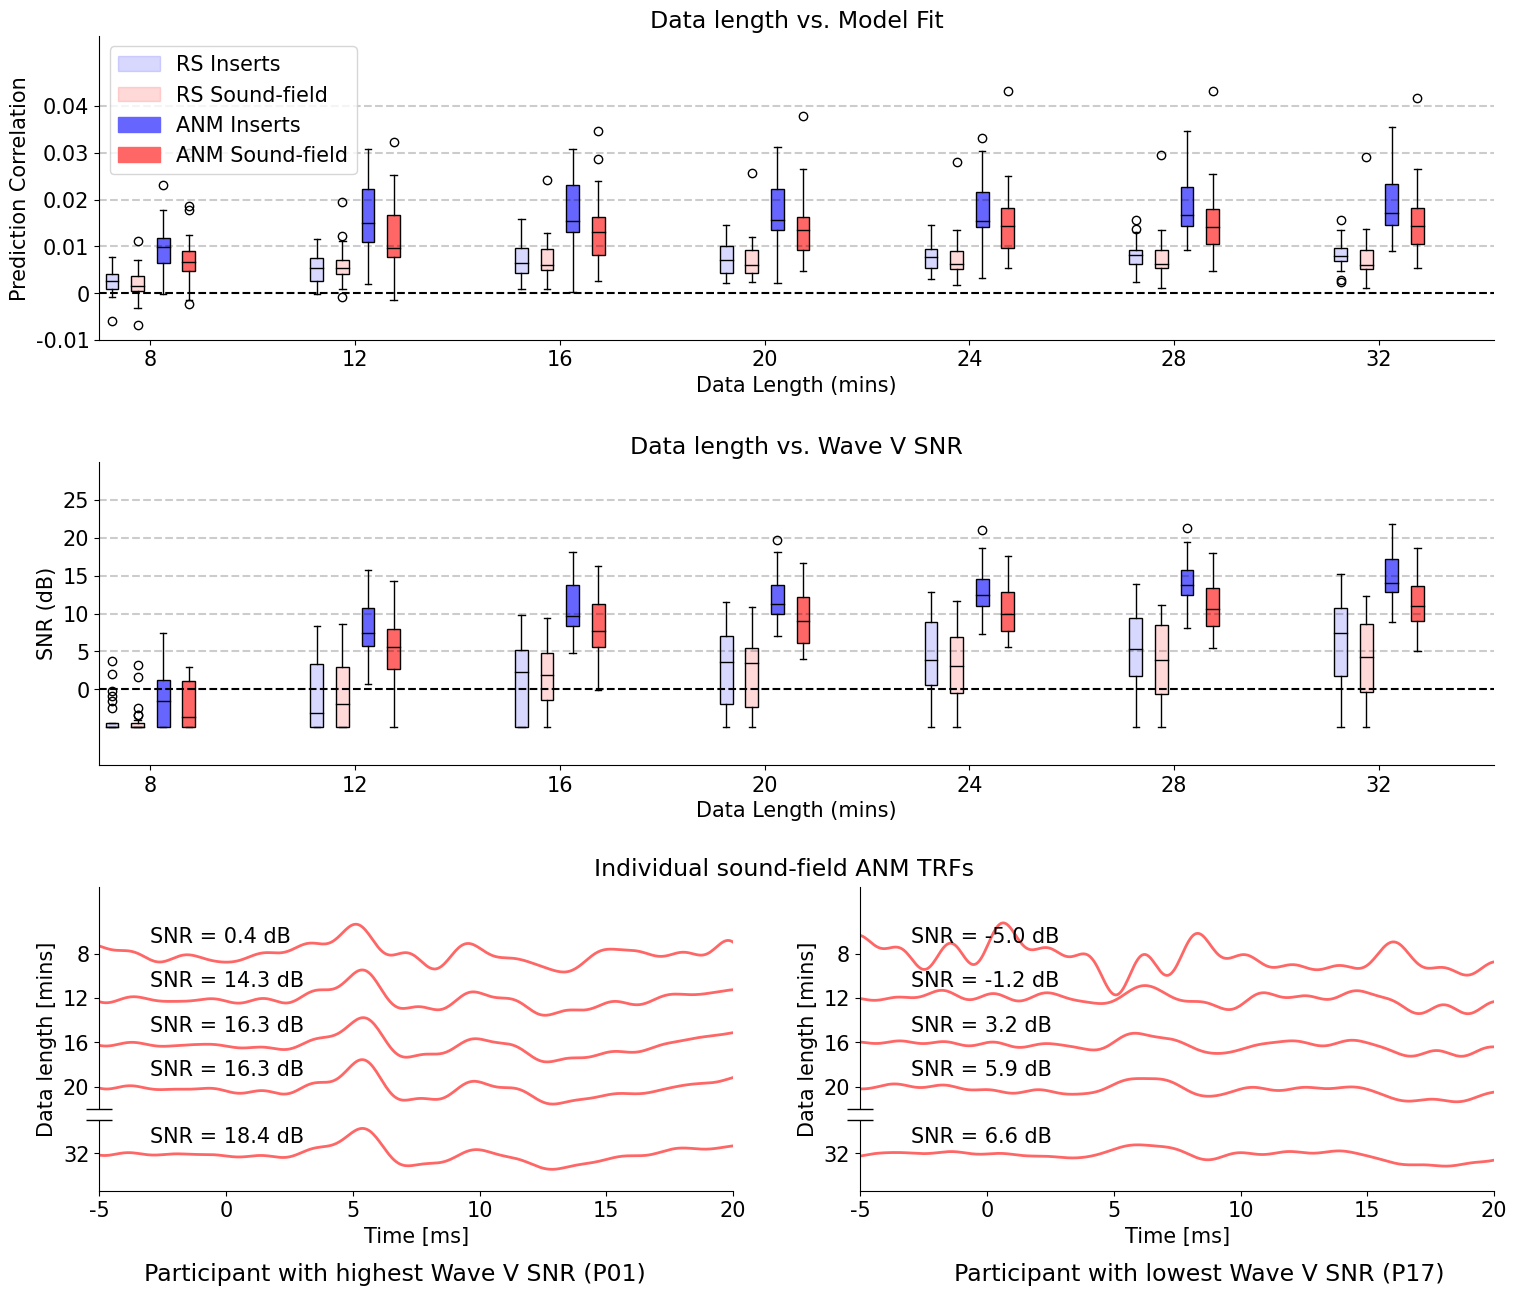

In [12]:
import matplotlib.patches as mpatches

#colors = [(0,0,1,0.5), (0,0.5,0.8,0.5), (1,0,0,0.5), (0.8,0.5,0,0.5), (0,1,0,0.5), (0.5,0.8,0,0.5)]
colors = [(0.5, 0.5, 1, 0.3), (1, 0.5, 0.5, 0.3), (0.4, 0.4, 1), (1, 0.4, 0.4)]    

plt.figure(figsize=(18,15))

patches = []
plt.subplot(3,1,1)
for ii, (k, color, label) in enumerate(zip(['in_speech_RS', 's_speech_RS', 'in_speech_AN', 's_speech_AN'], colors, 
                                                ['RS Inserts', 'RS Sound-field', 'ANM Inserts', 'ANM Sound-field'])):
    print(k)
    bplot = plt.boxplot([[corrtrialdict[k][isubj][ilev]-corrdict[k+'null'][isubj] for isubj in range(len(corrtrialdict[k])) if len(corrtrialdict[k][isubj])>ilev] for ilev in range(7)], 
                        positions=[i*8+ii for i in range(7)], patch_artist=True)
    
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
    for m in bplot['medians']:
        m.set_color('black')
    patches.append(mpatches.Patch(color=color, label=label))
plt.title('Data length vs. Model Fit', fontsize=17)
plt.legend(handles=patches, fontsize=15)
plt.xlabel('Data Length (mins)', fontsize=15)
plt.xlim([-0.5, 6*8+6])
plt.xticks([i*8+1.5 for i in range(7)])
plt.gca().set_xticklabels([4*(i+2) for i in range(7)], fontsize=15)
plt.yticks([-0.01, 0, 0.01, 0.02, 0.03, 0.04])
plt.gca().set_yticklabels([-0.01, 0, 0.01, 0.02, 0.03, 0.04], fontsize=15)
plt.ylim([-0.01, 0.055])
for yy in [0.01, 0.02, 0.03, 0.04]:
    plt.axhline(yy, color='k', alpha=0.2, linestyle='dashed')
plt.axhline(0, color='k', linestyle='dashed')
plt.ylabel('Prediction Correlation', fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.subplot(3,1,2)
patches = []
for ii, (k, color, label) in enumerate(zip(['in_speech_RS', 's_speech_RS', 'in_speech_AN', 's_speech_AN'], colors, 
                                                ['RS IE', 'RS SF', 'ANM IE', 'ANM SF'])):
    print(k)
    bplot = plt.boxplot([[snrdict[k][isubj][ilev] for isubj in range(len(snrdict[k])) if len(snrdict[k][isubj])>ilev] for ilev in range(7)], 
                        positions=[i*8+ii for i in range(7)], patch_artist=True)
    
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
    for m in bplot['medians']:
        m.set_color('black')
    patches.append(mpatches.Patch(color=color, label=label))
plt.xlim([-0.5, 6*8+6])
plt.ylim([-10, 30])
plt.xticks([i*8+1.5 for i in range(7)])
plt.gca().set_xticklabels([4*(i+2) for i in range(7)], fontsize=15)
plt.yticks([0, 5, 10, 15, 20, 25])
plt.gca().set_yticklabels([0, 5, 10, 15, 20, 25], fontsize=15)
plt.title('Data length vs. Wave V SNR', fontsize=17)
for yy in [5, 10, 15, 20, 25]:
    plt.axhline(yy, color='k', alpha=0.2, linestyle='dashed')
plt.axhline(0, color='k', linestyle='dashed')
plt.ylabel('SNR (dB)', fontsize=15)
plt.xlabel('Data Length (mins)', fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(3,2,5)
tdim = trftrialdict['s_speech_AN'][0][0].time.times*1000
tnorm = trftrialdict['s_speech_AN'][0][-1].sub(time=(-0.01,0)).std()*1.2
for i in range(4):
    tt = trftrialdict['s_speech_AN'][0][4-i-1]
    plt.plot(tdim, tt.x/tnorm + 20*i, color=(1, 0.4, 0.4), lw=2)
    plt.text(-3, 20*i+5, f'SNR = {snrdict["s_speech_AN"][0][4-i-1]:.1f} dB', fontsize=15)
tt = trftrialdict['s_speech_AN'][0][-1]
plt.plot(tdim, tt.x/tnorm-30, color=(1, 0.4, 0.4), lw=2)
plt.text(-3, -30+5, f'SNR = {snrdict["s_speech_AN"][0][-1]:.1f} dB', fontsize=15)
plt.yticks([-30]+[i*20 for i in range(4)])
plt.ylim([-47, 20*4+10])
plt.gca().set_yticklabels([32, 20, 16, 12, 8], fontsize=15)
plt.gca().set_xticklabels([i for i in np.arange(-5, 21, 5)], fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('Data length [mins]', fontsize=15)
plt.xlim([-5, 20])
plt.gca().set_xticklabels([i for i in np.arange(-5, 21, 5)], fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
rect = mpatches.Rectangle((-5.5, -15), 1, 5, linewidth=1, edgecolor='none', zorder=3, facecolor=(1,1,1), clip_on=False)
plt.gca().add_patch(rect)
rect = mpatches.Rectangle((-5.5, -10), 1, 0.1, linewidth=1, edgecolor='k', zorder=3, facecolor='none', clip_on=False)
plt.gca().add_patch(rect)
rect = mpatches.Rectangle((-5.5, -15), 1, 0.1, linewidth=1, edgecolor='k', zorder=3, facecolor='none', clip_on=False)
plt.gca().add_patch(rect)

plt.subplot(3,2,6)
tnorm = trftrialdict['s_speech_AN'][16][-1].sub(time=(-0.01,0)).std()*1.5
for i in range(4):
    tt = trftrialdict['s_speech_AN'][16][4-i-1]
    plt.plot(tdim, tt.x/tnorm + 20*i, color=(1, 0.4, 0.4), lw=2)
    plt.text(-3, 20*i+5, f'SNR = {snrdict["s_speech_AN"][16][4-i-1]:.1f} dB', fontsize=15)
tt = trftrialdict['s_speech_AN'][16][-1]
plt.plot(tdim, tt.x/tnorm-30, color=(1, 0.4, 0.4), lw=2)
plt.text(-3, -30+5, f'SNR = {snrdict["s_speech_AN"][16][-1]:.1f} dB', fontsize=15)
plt.yticks([-30]+[i*20 for i in range(4)])
plt.ylim([-47, 20*4+10])
plt.gca().set_yticklabels([32, 20, 16, 12, 8], fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('Data length [mins]', fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim([-5, 20])
plt.gca().set_xticklabels([i for i in np.arange(-5, 21, 5)], fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)

plt.figtext(0.4, 0.32, 'Individual sound-field ANM TRFs', fontsize=17)
plt.figtext(0.6, 0.05,'Participant with lowest Wave V SNR (P17)', fontsize=17)
plt.figtext(0.15, 0.05,'Participant with highest Wave V SNR (P01)', fontsize=17)

rect = mpatches.Rectangle((-5.5, -15), 1, 5, linewidth=1, edgecolor='none', zorder=3, facecolor=(1,1,1), clip_on=False)
plt.gca().add_patch(rect)
rect = mpatches.Rectangle((-5.5, -10), 1, 0.1, linewidth=1, edgecolor='k', zorder=3, facecolor='none', clip_on=False)
plt.gca().add_patch(rect)
rect = mpatches.Rectangle((-5.5, -15), 1, 0.1, linewidth=1, edgecolor='k', zorder=3, facecolor='none', clip_on=False)
plt.gca().add_patch(rect)

plt.subplots_adjust(hspace=0.4)
out_path1 = savepath
plt.savefig(out_path1 / 'datalength.png', bbox_inches='tight', dpi=300)
plt.savefig(out_path1 / 'datalength.pdf', bbox_inches='tight', dpi=300)

# plot individuals

E:\LiU\Projects\FreefieldABR\SFABR_rev1.0\post_analysis_006\figs_rev1_06


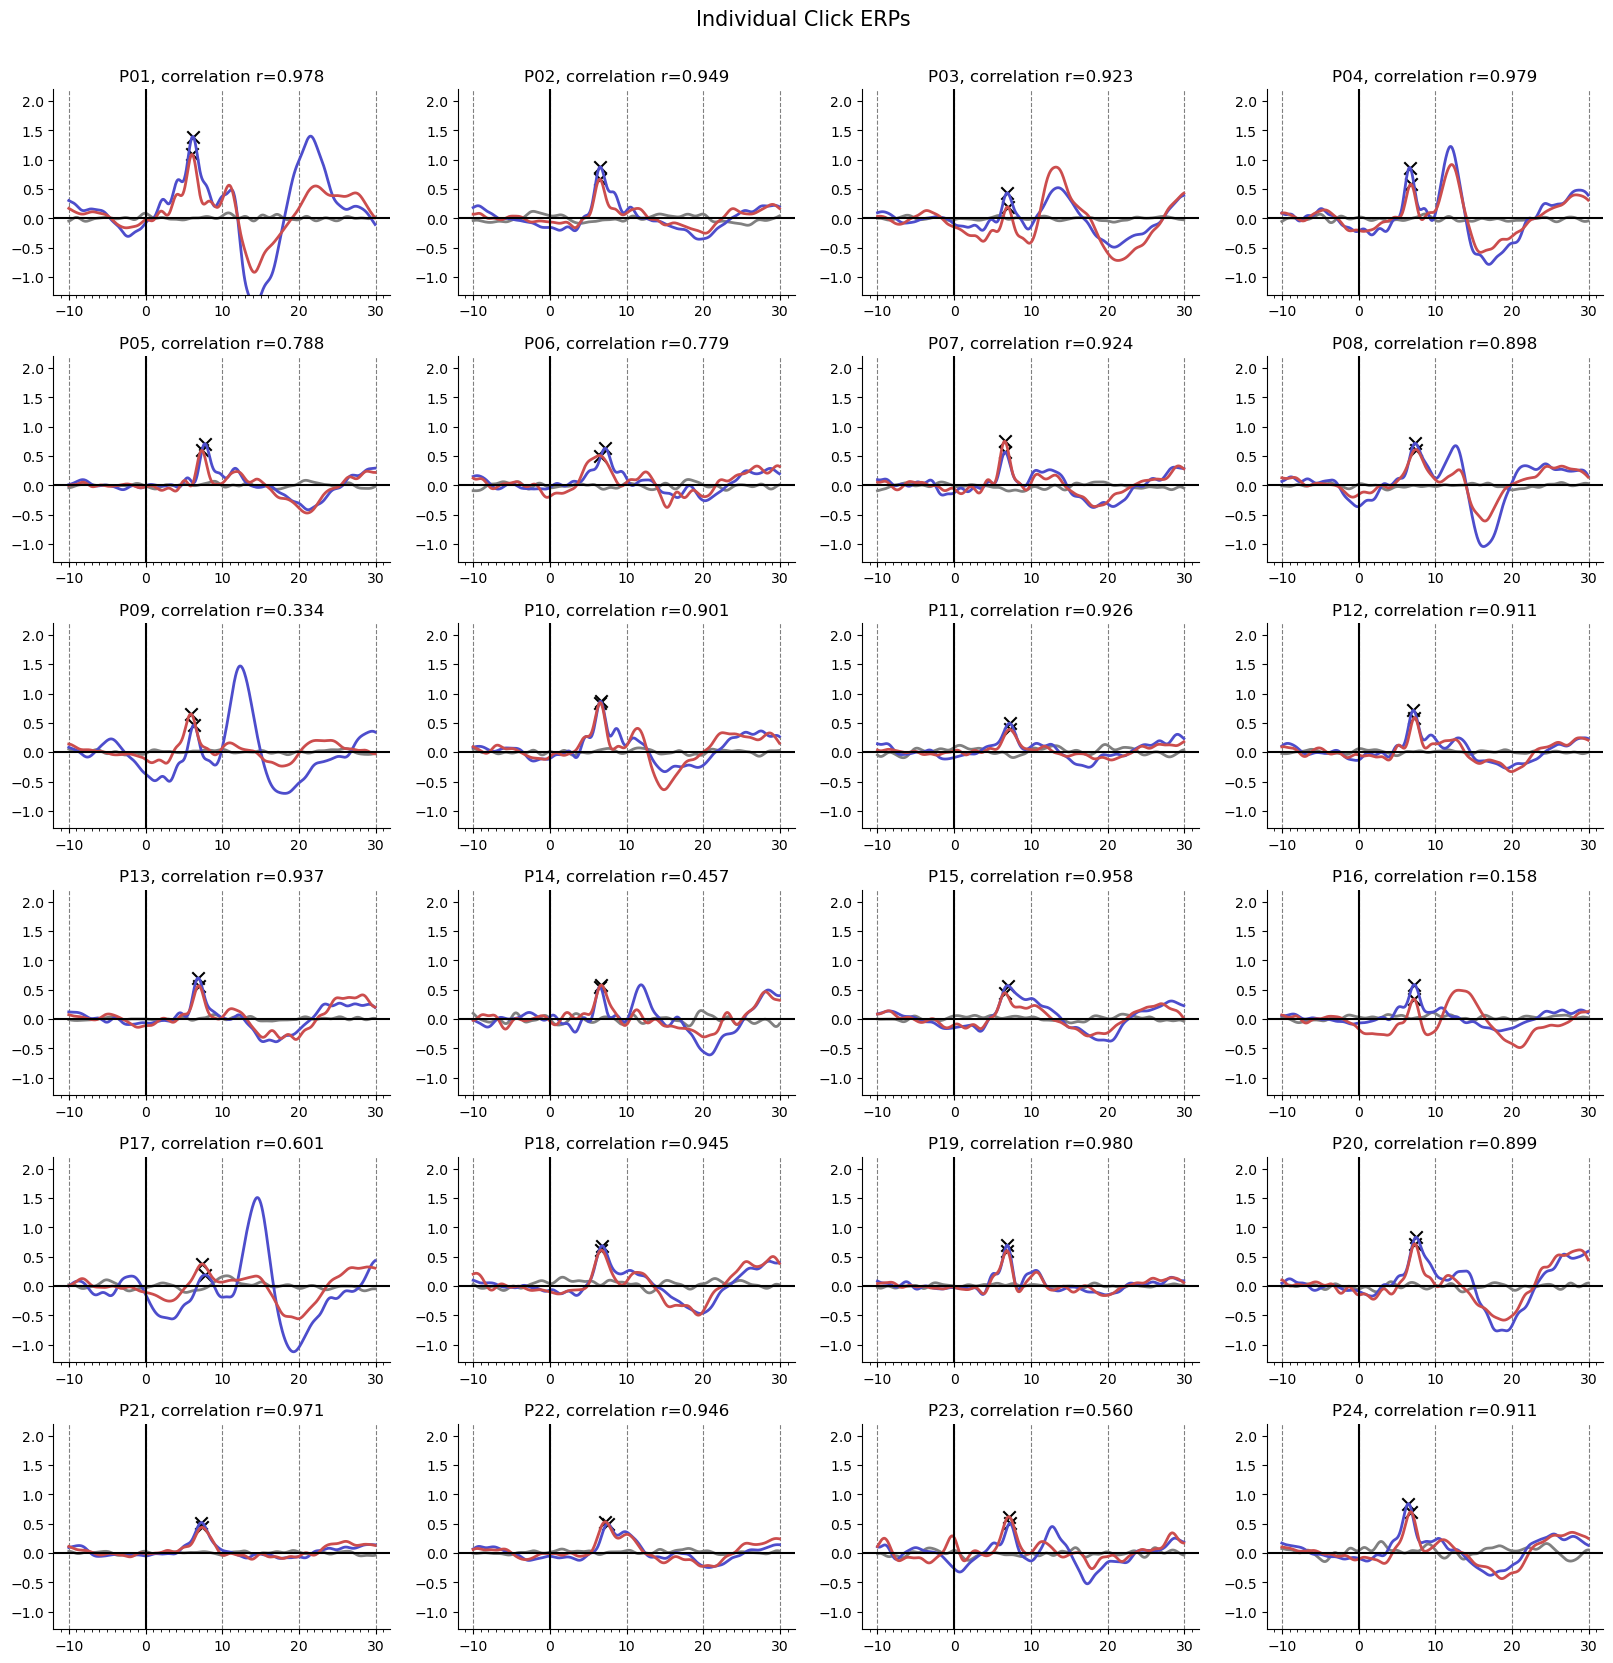

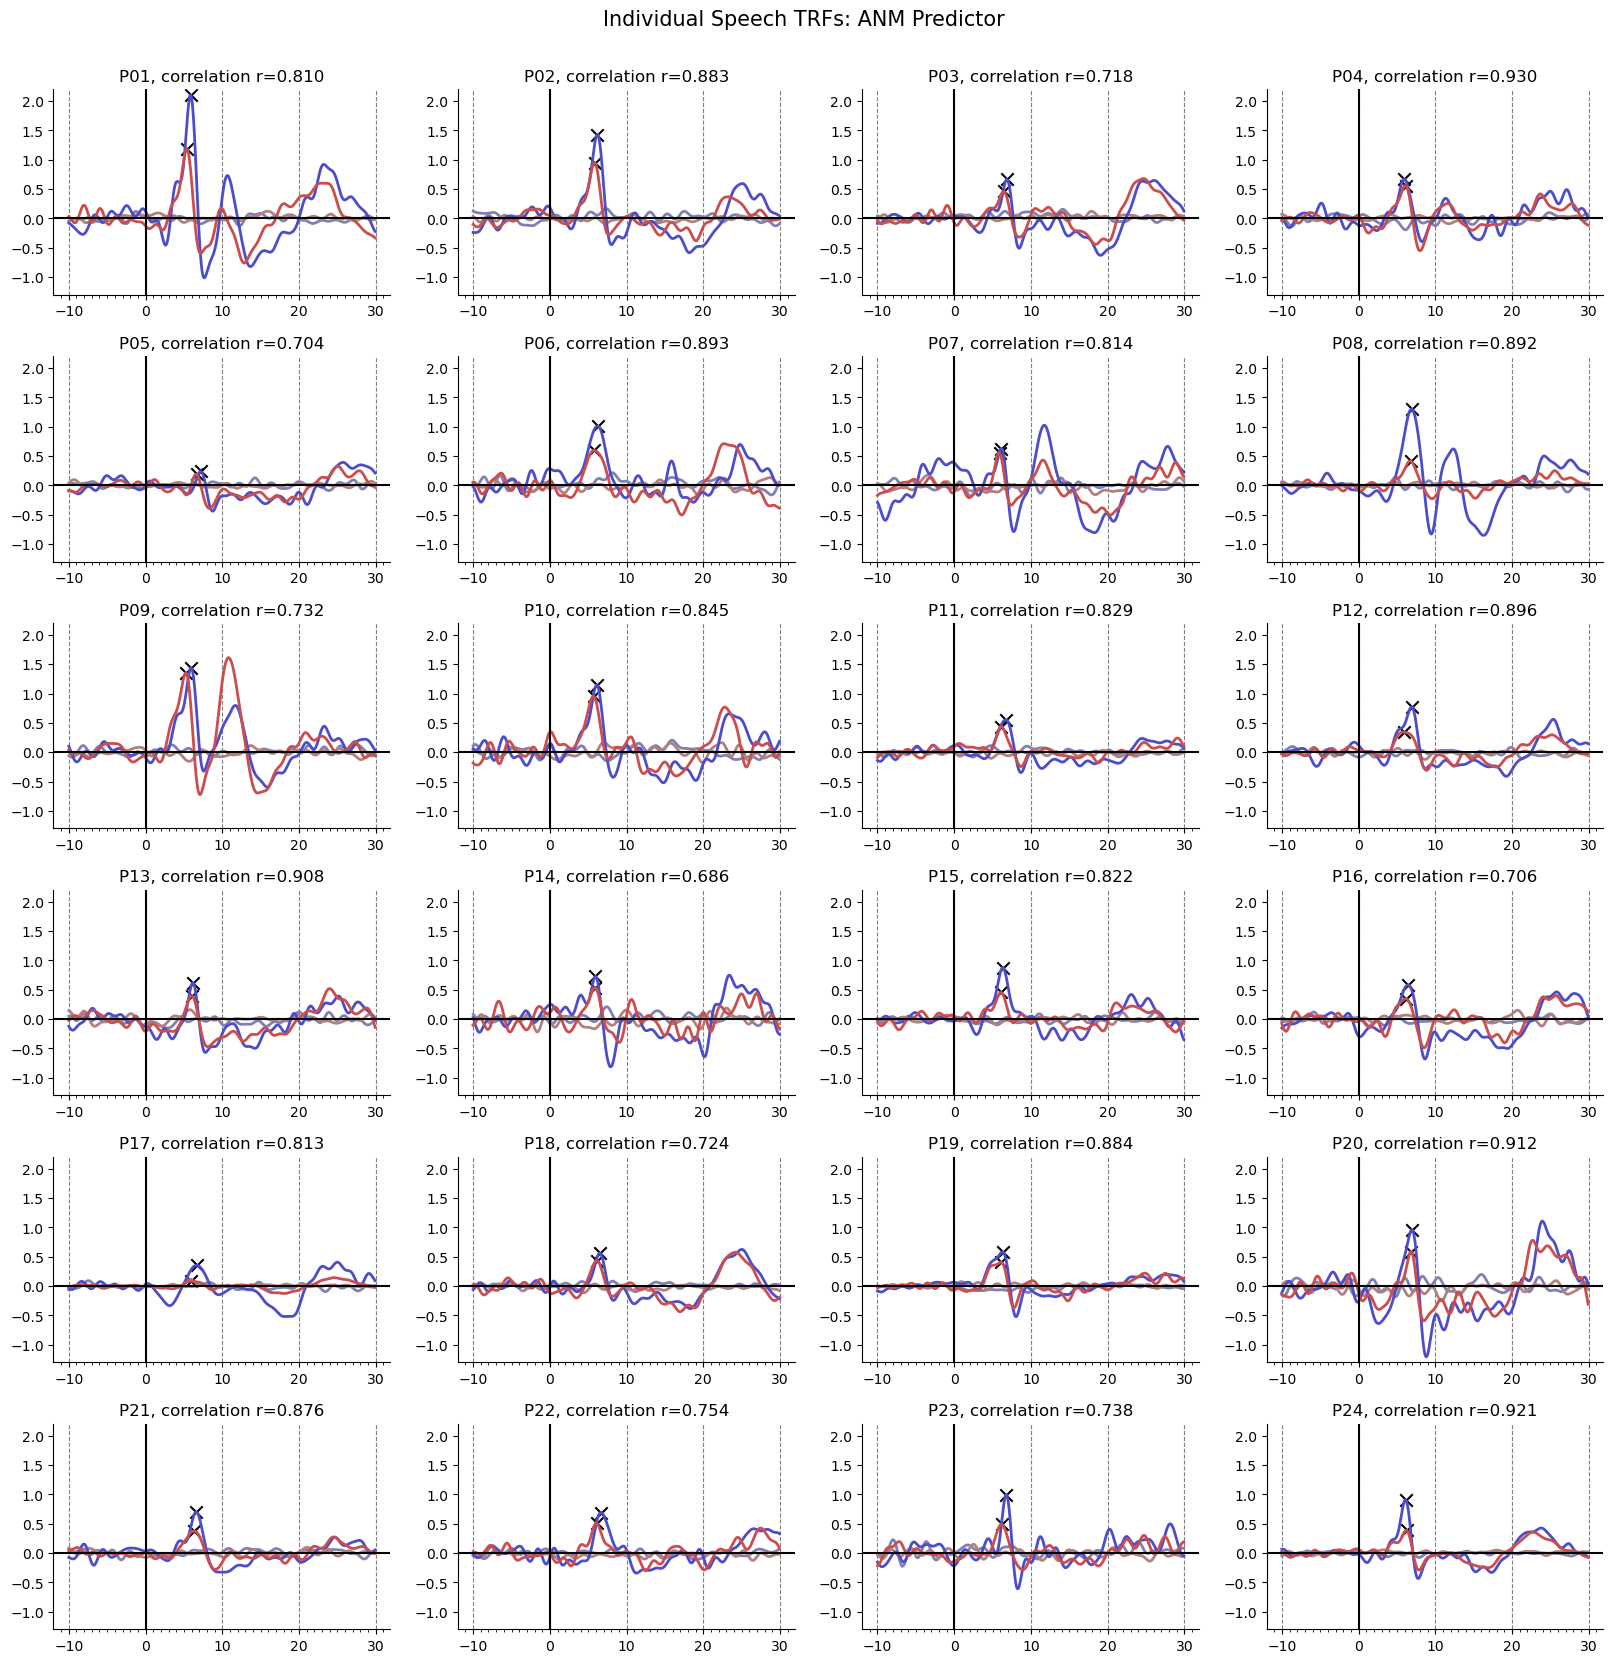

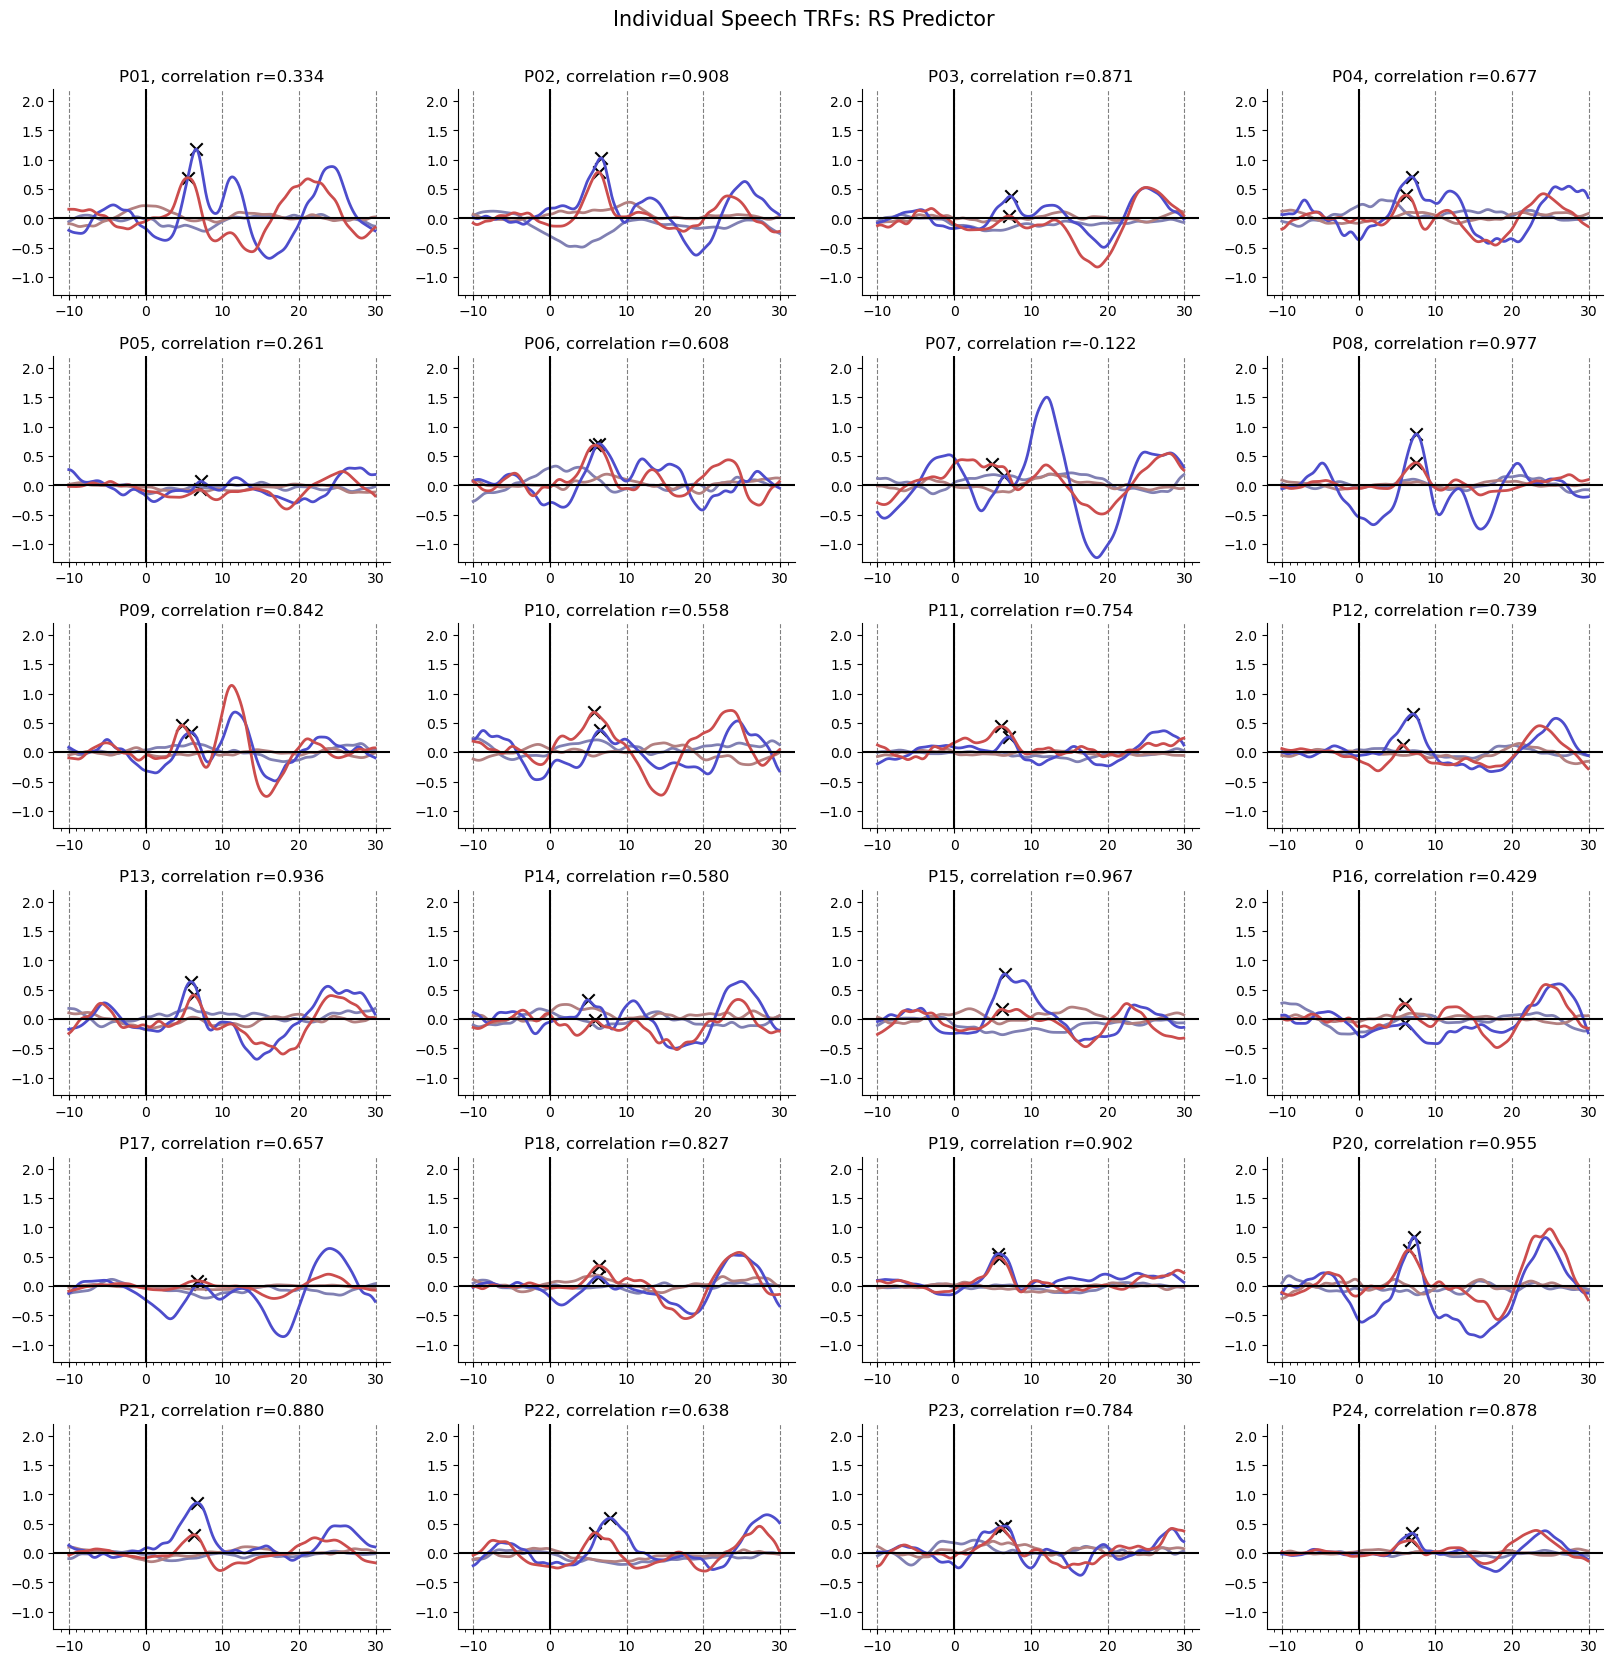

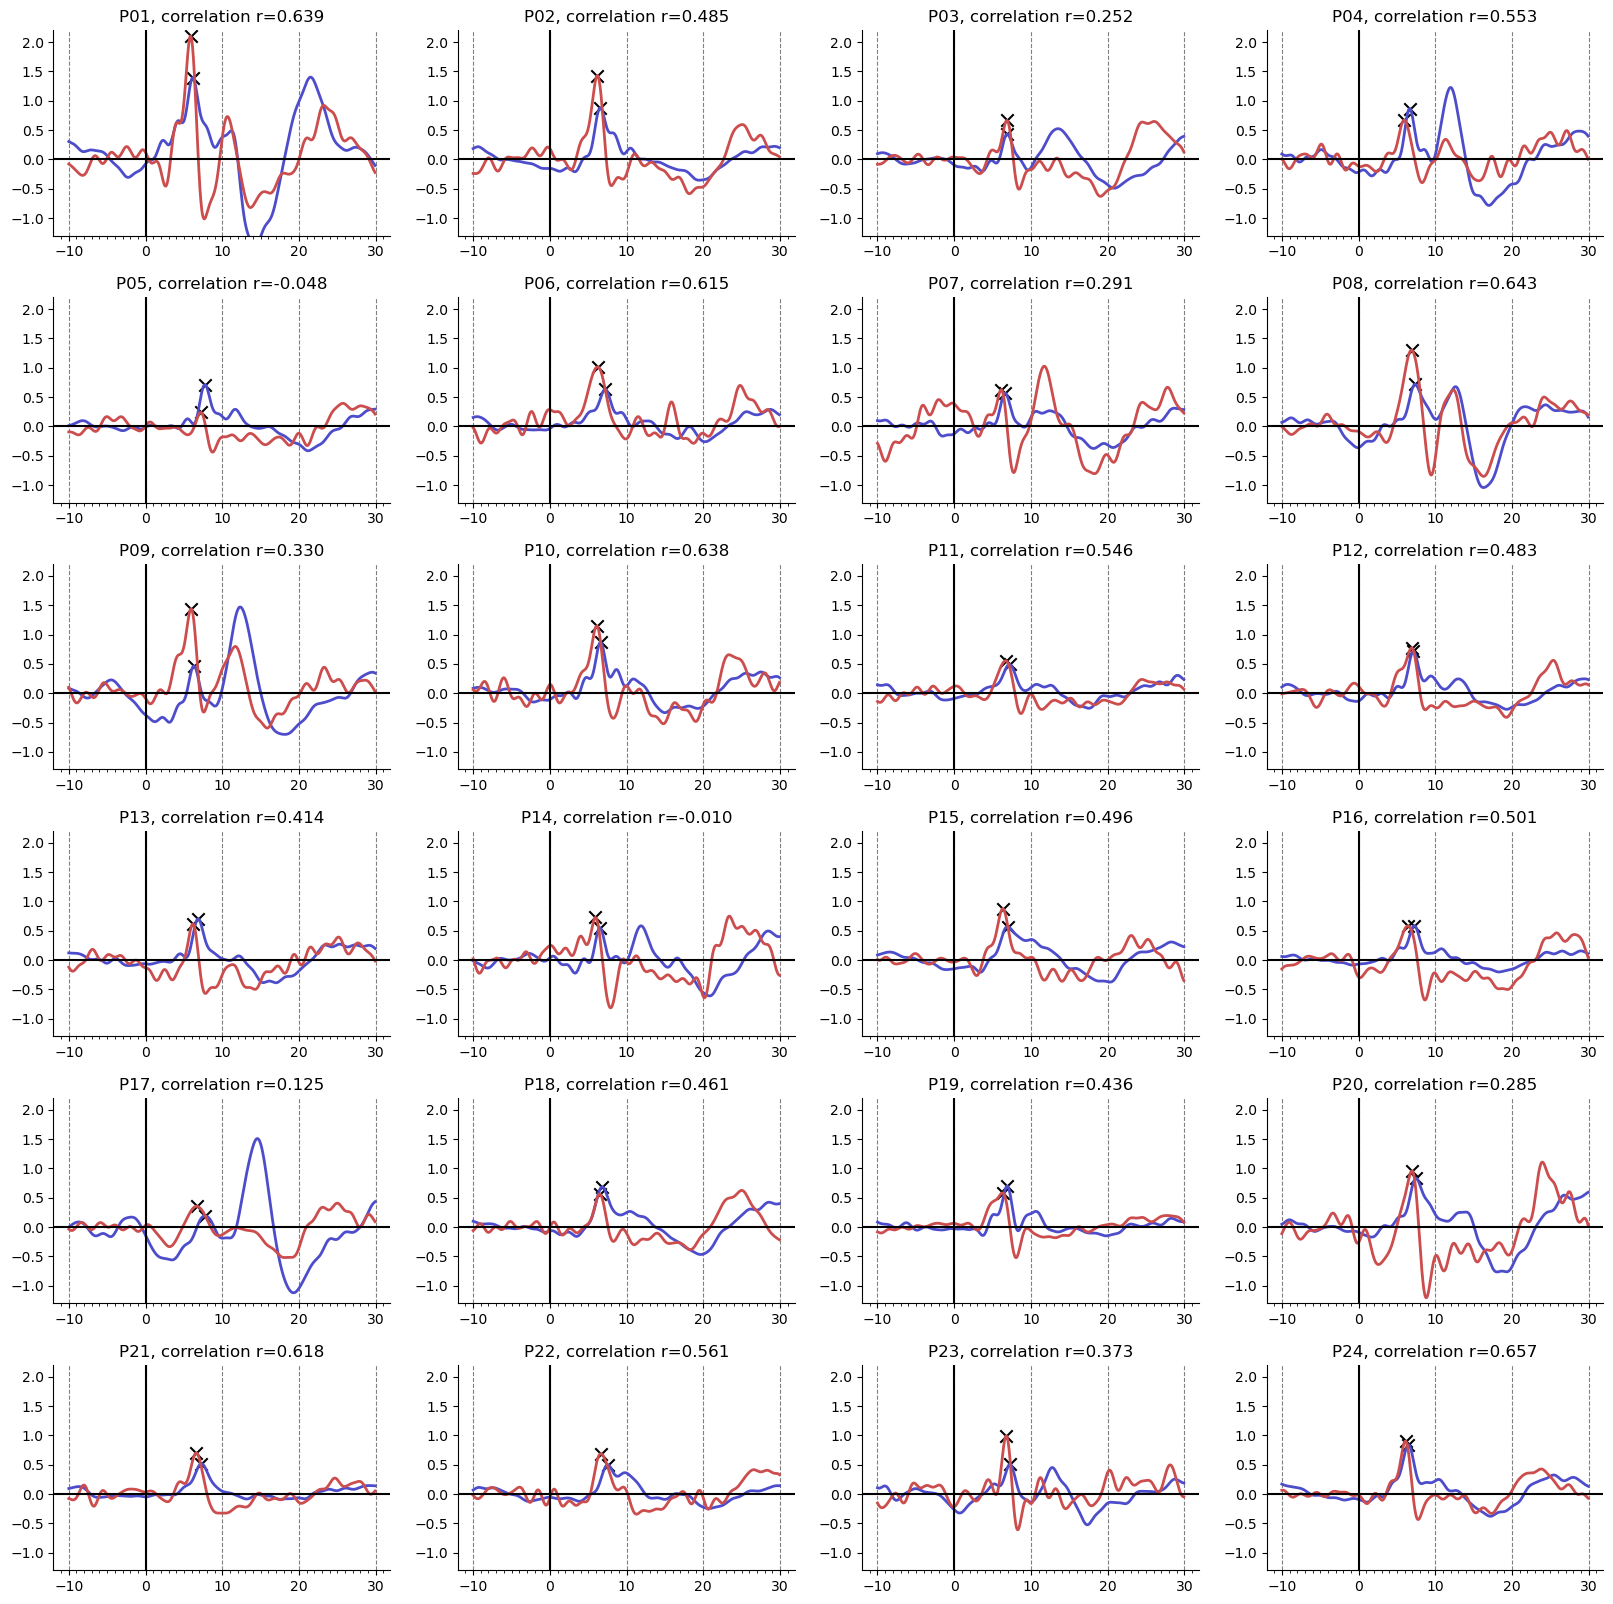

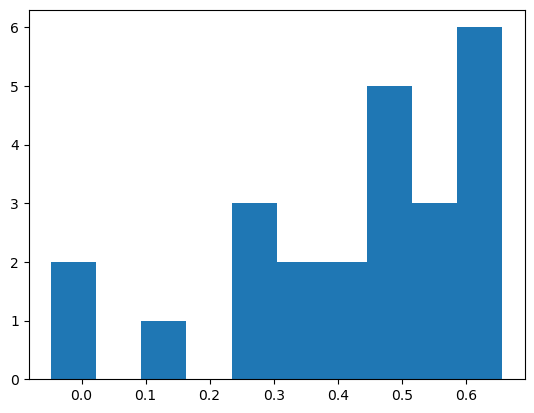

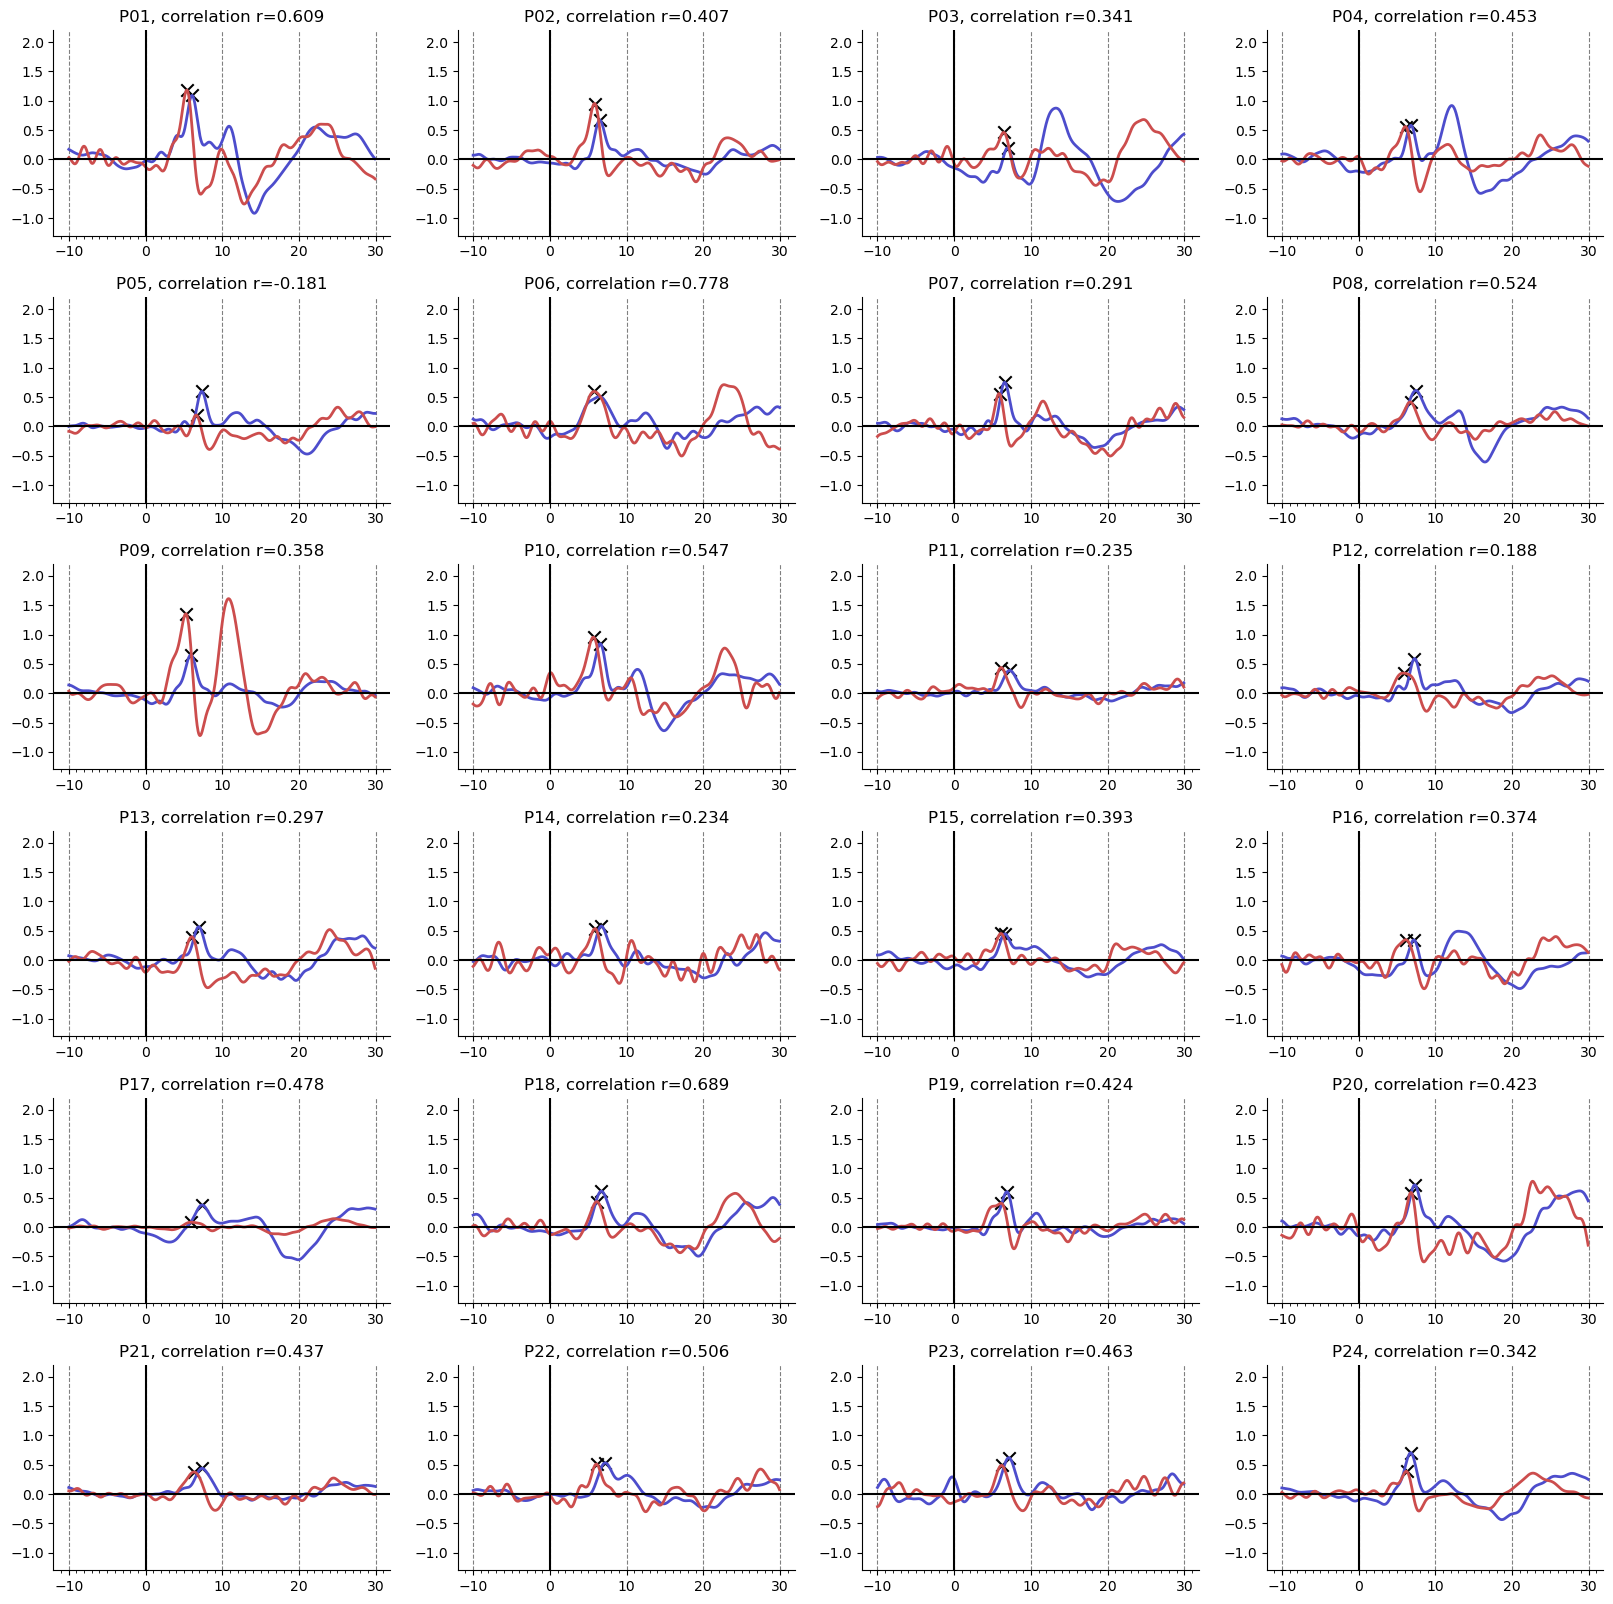

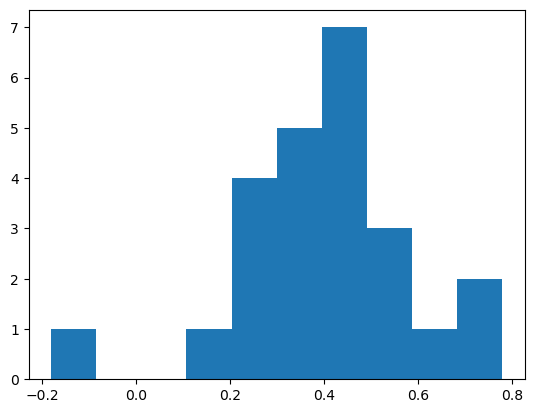

In [13]:
importlib.reload(plotting)
savepath.mkdir(exist_ok=True)
print(savepath)
plotting.plot_fig_indivTRFs(resdict, pklatsdict, pkampsdict, savepath, saveflag=True)